# 배경지식

- 산란일사량(DHI) : 대기중의 공기 분자나 부유 입자에 충돌하여 여러 방향으로 산란된 일사량

- 직달 일사량(DNI) : 대기중의 수증기나 작은 먼지에 흡수되지 않은 채로, 태양으로부터 직접 지표면에 도달하는 일사량이다. 이 떄에 지표면에서 태양과 직각인 면에 도달하는 일사량이다.
    - 직달 일사량은 날씨에 따라 강도가 다르다. 맑은날에는 보통 직달일사량이 전천일사량보다 크지만, 흐린날에는 직달 일사량이 매우 작고 전천일사량이 훨씬 크다.
    
- 전천 일사량(GHI) : 수평면에 입사하는 직달일사 및 산란 복사를 합친것을 말한다.

- GHI = DNI * COS천정각(90-태양의 고도)+산란일사량

- Hour - 시간
- Minute - 분
- DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
- DNI - 직달일사량(Direct Normal Irradiance (W/m2))
- WS - 풍속(Wind Speed (m/s))
- RH - 상대습도(Relative Humidity (%))
- T - 기온(Temperature (Degree C))
- Target - 태양광 발전량 (kW)


# 모델링 아이디어

- 회귀를 쓸 것이라면, 1일치로 나머지 2일치를 추정하는것이 좋아보인다. (태양광은 이전것의 결과가 심하게 누적되는 편이 아니다. Markov chain 처럼 이전의 값이 주어지면 그 전 값들과는 독립성을 띤다고 생각이 된다. )
- 하지만.. 어쩃든 그 이전에 대한 평균을 내 주어야 할 것 같다는 생각?
- 다만, 이전 3일치에 대한 가중평균을 해서, 최근 1일치의 값이 크게 반영되게 하는것이 좋아보인다. 
- 일 평균 기온을 쓴다면, 기온 -> 계절 -> 일조량 이라는 Measure 가 가능해보인다...!
- 전날 바뀌는 양상이 궁금한게 아니다. 전날에 '어떤' 값을 가지고 있느냐가 중요. 
- 변화가 비교적 중요한것
    - 습도(전날 습도가 큰 영향) 
    - 바람(바람의 경우 전날 바람이 꽤 큰 영향)
    - 근데 전날 바람으로 추정하는건 정말 의미없던데?
    - 위 세가지의 경우 7일치를 쓰되, 가중치를 전날을 크게 하여서 예측 해야될 것 같다.
    - (0.01,0.02,0.03.0.04,0.05,0.2,0.65)
- 변화가 중요하지 않고, 7일치가 필요(절대 크게 변하지 않을 값)
- 크게 변하지는 않을 값.
    - 온도
    - 수평면 산란일사량
    - 직달일사량  
    - (0.1,0.1,0.1,0.1,0.1,0.15,0.35)
- 7일 가중평균 된 온도를 이용하여
    - 태양각 계산
- 무조건 그대로 써야되는 값
    - 시간
    - Sine 시간..?
- 고민중 
    - 습도 100% 인 경우 비가 오는 날일텐데, 1 변수를 넣어야 할까?
    - upsampling 을 진행해야할까? 아니면 소수 정예로만 이끌어야 할까?
    - 시간 변수에 대해 sin 변환이 과연 유의미할까? 

- 시계열을 쓴다 해도, 그 뒤의 2일의 변화를 잘 담아낼 수 있을까? (비오면..?) (갑자기 바람 많이 불면..?)
- 안쓴다고 하면 이전 예측치들의 변동은 사실 1일 후에는 아무짝에도 없는 변동들인데.. 진짜 얘네들 이동평균 하는게 맞지 않으려나?
- 현재 모델은 '같은 시각' 의 값을 이용, 1일 또는 2일 후의 예측이다. 이것은 겁나 무리수인데 어떻게 1일 후의 값을 똑같이 맞추냐!
- 내 생각은 결국 왜 pinball loss 를 주었느냐로 수렴하였다.
    - 그렇다. 이런 경우 어쩔수 없이 오차가 생길 수 밖에 없다.
    - 1일 이후에 비, 눈이 올지 이건 분~~ 명 아무도 모르는 일이고 알 수 도 없다.
    - 그렇다면! 추정해야될것은 뭐냐? 바로 적절한 '대표성' 이다. 정확성이 아닌
    - 대표성을 띄게 하려면 이전의 7일치들의 이동평균을 멕여서 하는것이 제일 좋아보인다.
    - 바람의 경우 : 이전 7일의 경향을 알아볼 수 있으면 좋겠지만, 그게 안될거 같다.
- 1일 후 모델과 2일 후 모델을... 같이 추정하는것은 미친짓이다.
- 두 모델의 가중치를 다르게 하는것이 좋아보인다.

# module import 

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import seaborn as sns
import math
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from platform import python_version

os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
random.seed(42)
#import warnings
#warnings.filterwarnings("ignore")

In [2]:
print(f'python version: {python_version()}')
print(f'numpy version : {np.__version__}')
print(f'pandas version : {pd.__version__}')

python version: 3.7.4
numpy version : 1.19.1
pandas version : 1.1.1


In [3]:
# train 데이터 불러오기
train = pd.read_csv('./data/train/train.csv')

In [4]:
df_train = train.copy()

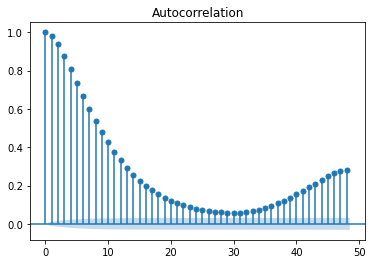

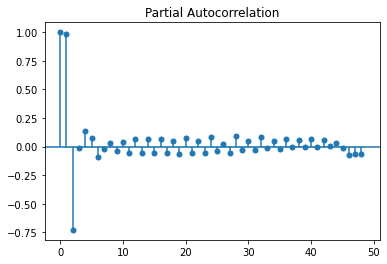

In [5]:
plot_acf(df_train['WS'])
plot_pacf(df_train['WS'])
plt.show()

In [6]:
# train 데이터 살펴보기
df_train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [7]:
# 제출 데이터 불러오기
submission = pd.read_csv('./data/sample_submission.csv')

In [8]:
# 제출 데이터 살펴보기
submission.tail()

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7775,80.csv_Day8_23h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 데이터 살펴보기

In [9]:
df_train.shape

(52560, 9)

In [10]:
sum(df_train['RH'] == 100)/df_train.shape[0]

0.02332572298325723

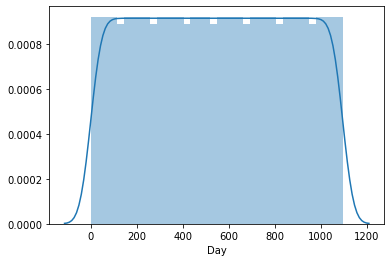

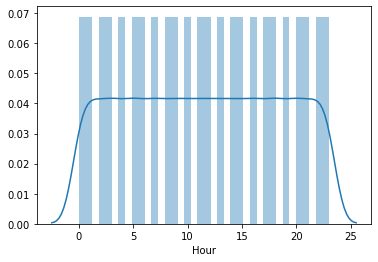

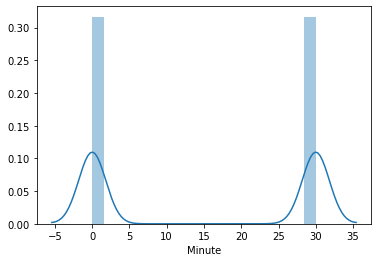

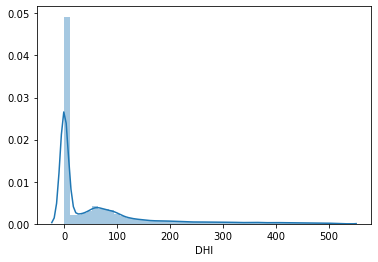

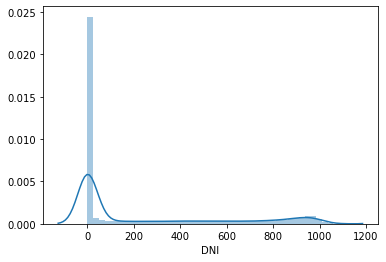

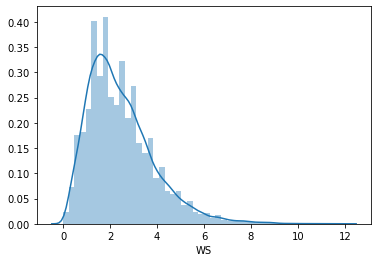

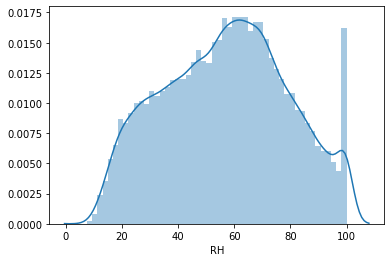

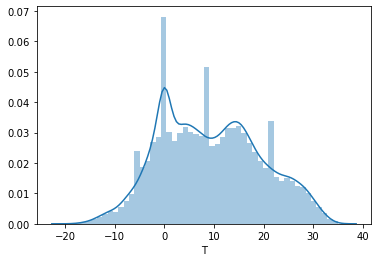

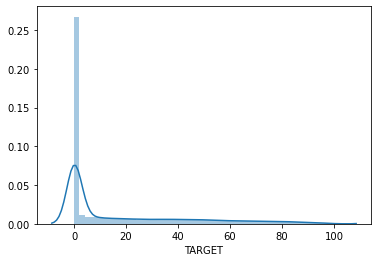

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
df=df_train
for i, col in enumerate(df.columns):
    plt.figure(i)
    sns.distplot(df[col])

In [12]:
# NA 가 없음
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [13]:
# 데이터의 type 은 잘 정의되어있다.(not categorical)
df_train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


# 이동평균

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Day     52560 non-null  int64  
 1   Hour    52560 non-null  int64  
 2   Minute  52560 non-null  int64  
 3   DHI     52560 non-null  int64  
 4   DNI     52560 non-null  int64  
 5   WS      52560 non-null  float64
 6   RH      52560 non-null  float64
 7   T       52560 non-null  int64  
 8   TARGET  52560 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 3.6 MB


In [15]:
palette = ["#07d7e8", "#07f2f9", 
           "#f9ac07", "#c77406", "#963b04", "#640303"]

def plot(df,x,names):
    ax = sns.lineplot(range(0,48),y=df.loc[x*48:x*48+47,names],color='darkseagreen')
    ax = sns.lineplot(range(0,48),y=df.loc[x*48+1*48:x*48+47+1*48,names],color='gold')
    ax = sns.lineplot(range(0,48),y=df.loc[x*48+2*48:x*48+47+2*48,names],color='orange')
    ax = sns.lineplot(range(0,48),y=train.loc[x*48+3*48:x*48+47+3*48,names],color='red')
    ax = sns.lineplot(range(0,48),y=train.loc[x*48+4*48:x*48+47+4*48,names],color='black')

In [16]:
str(3) + str(3)

'33'

In [17]:
df_train.shape

(52560, 9)

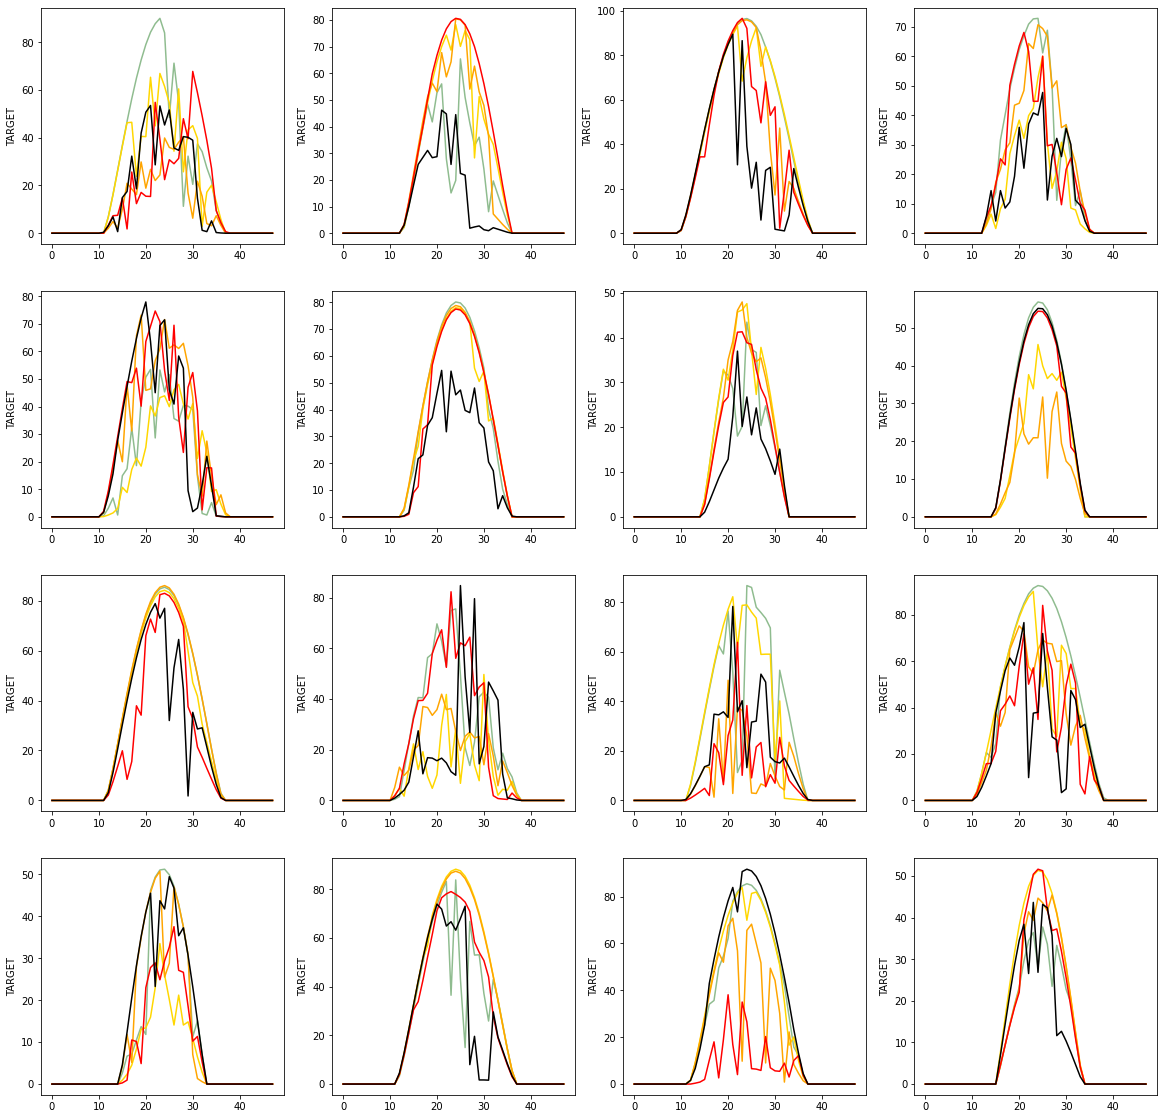

In [18]:
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    plot(df_train,np.random.randint(1,1000),'TARGET')

def data(df):
    w=[0.01,0.02,0.03,0.04,0.05,0.2,0.65]
    highcol = ['WS','RH','T']
    temp = df.copy()
    df_new = (w[0]*temp[high_col] + 
              w[1]*temp[high_col].shift(-48) + 
              w[2]*temp[high_col].shift(-48*2) + 
              w[3]*temp[high_col].shift(-48*3) + 
              w[4]*temp[high_col].shift(-48*4) + 
              w[5]*temp[high_col].shift(-48*5) + 
              w[6]*temp[high_col].shift(-48*6) )
    w2=[0.1,0.1,0.1,0.1,0.1,0.15,0.35]
    low_col = ['DHI','DNI','TARGET']
    df_new2 = (w[0]*temp[low_col] + 
               w[1]*temp[low_col].shift(-48) + 
               w[2]*temp[low_col].shift(-48*2) + 
               w[3]*temp[low_col].shift(-48*3) + 
               w[4]*temp[low_col].shift(-48*4) + 
               w[5]*temp[low_col].shift(-48*5) + 
               w[6]*temp[low_col].shift(-48*6) )
    df[highcol] = df_new
    df[low_col] = df_new2
    df.dropna(inplaca=True)
    return(df)

In [19]:
def data(df):
    w7=[1/7,1/7,1/7,1/7,1/7,1/7,1/7]
    col = ['DHI','DNI','WS','RH','T','TARGET']
    fixed = df.copy()
    temp = df.copy()
    
    df_7 = (w7[0]*temp[col] + 
            w7[1]*temp[col].shift(-48) + 
            w7[2]*temp[col].shift(-48*2) + 
            w7[3]*temp[col].shift(-48*3) + 
            w7[4]*temp[col].shift(-48*4) + 
            w7[5]*temp[col].shift(-48*5) + 
            w7[6]*temp[col].shift(-48*6)) # 오늘 이전의 7일의 평균
    df_1 = temp[col].shift(-48*6) # 오늘시점의 값 
    df[col] = df_1 # 오늘시점의 값을 대체함 
    df[['DHI7','DNI7','WS7','RH7','T7','TARGET7']] = df_7 # 7일 평균의 값으로 대체함
    df.dropna(inplace=True)
    return(df)

In [20]:
data(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7
0,0,0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,78.188571,-7.142857,0.0
1,0,0,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,77.395714,-7.000000,0.0
2,0,1,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,77.324286,-7.285714,0.0
3,0,1,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,76.440000,-7.285714,0.0
4,0,2,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,77.774286,-7.428571,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,0.0,2.428571,68.254286,-3.000000,0.0
52268,1088,22,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,0.0,2.514286,66.628571,-3.285714,0.0
52269,1088,22,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,0.0,2.471429,66.621429,-3.285714,0.0
52270,1088,23,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,0.0,2.514286,67.664286,-3.571429,0.0


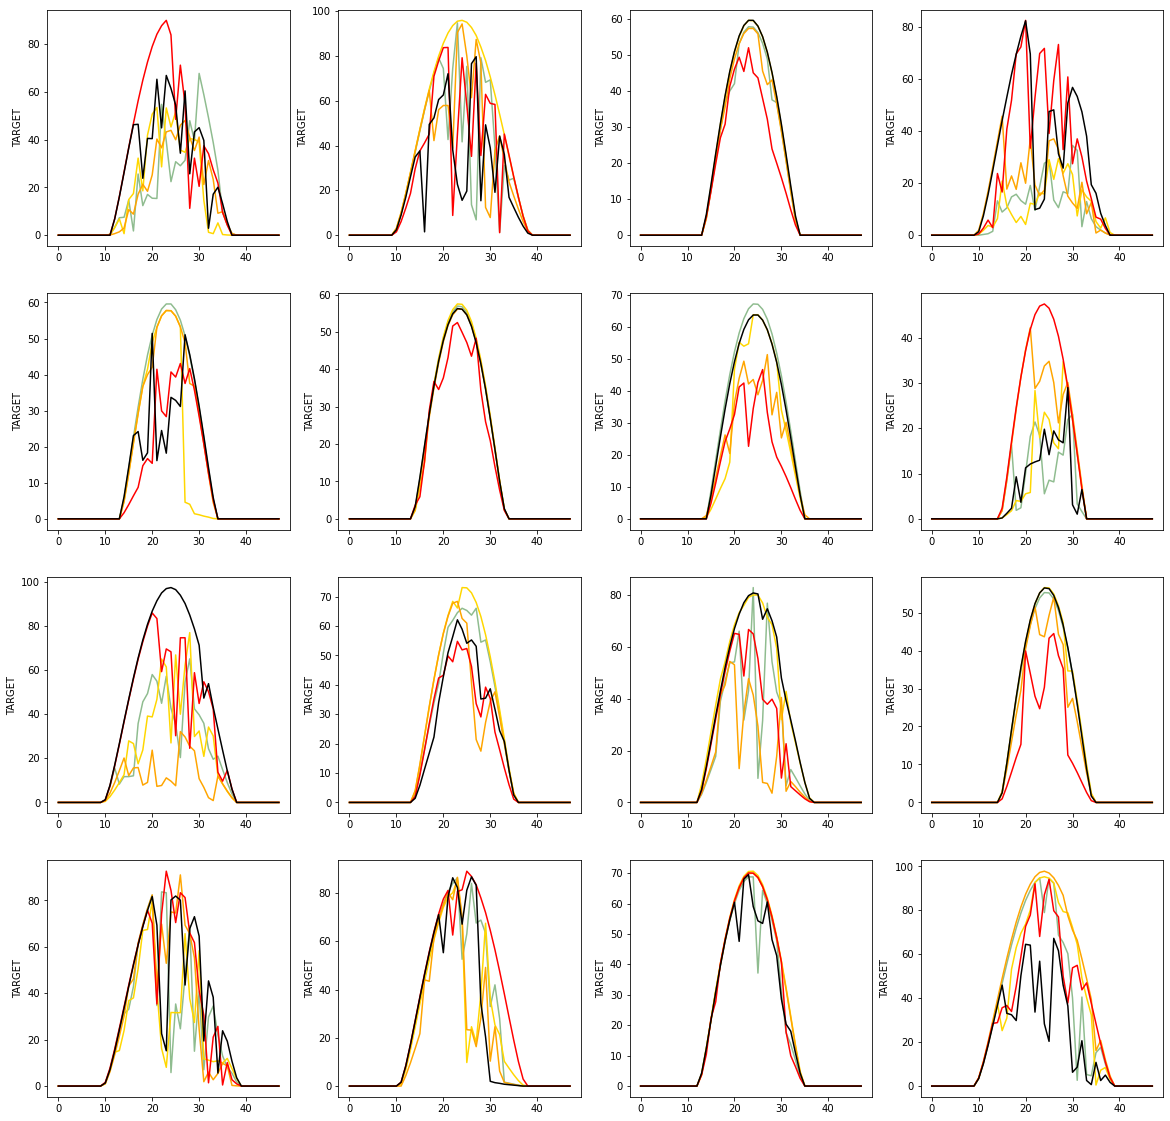

In [21]:
plt.figure(figsize=(20,20))
for i in range(1,17):
    plt.subplot(4,4,i)
    plot(df_train,np.random.randint(1,1000),'TARGET')

# EDA

## Hour 분 더하기

In [22]:
def hour(df):
    df['Hour'] = df['Hour'] + df['Minute']/60
    return(df)

In [23]:
hour(df_train) 

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,78.188571,-7.142857,0.0
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,77.395714,-7.000000,0.0
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,77.324286,-7.285714,0.0
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,76.440000,-7.285714,0.0
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,77.774286,-7.428571,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21.5,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,0.0,2.428571,68.254286,-3.000000,0.0
52268,1088,22.0,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,0.0,2.514286,66.628571,-3.285714,0.0
52269,1088,22.5,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,0.0,2.471429,66.621429,-3.285714,0.0
52270,1088,23.0,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,0.0,2.514286,67.664286,-3.571429,0.0


## 일 평균 넣기

- 계절성을 나타내면, 그에 따른 일조량도 자연스럽게 알 수 있기 때문에 매우 유용한 정보이다.
- 쓸 수 잇는 데이터는 온도(T) 밖에 없기때문에, 이를 이용해 최대한 계절성을 나타내고 싶었다.
- 그러므로 일 평균을 넣게 된다면, 겨울의 경우 낮은 값, 여름의 경우 높은 값을 나타내어 어느정도 날마다의 일조량을 근사하는 값이 될 수 있을것이다.

In [24]:
def Daymean_T(df) :
    df['Weekmean_T']= df['T7'].groupby(df['Day']).transform('mean')
    df['Weekmean_TARGET'] = df['TARGET7'].groupby(df['Day']).transform('mean')
    df['Daymean_TARGET'] = df['TARGET'].groupby(df['Day']).transform('mean')
    return(df)

In [25]:
Daymean_T(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,78.188571,-7.142857,0.0,-3.500000,6.573162,5.589715
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,77.395714,-7.000000,0.0,-3.500000,6.573162,5.589715
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,77.324286,-7.285714,0.0,-3.500000,6.573162,5.589715
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,76.440000,-7.285714,0.0,-3.500000,6.573162,5.589715
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,77.774286,-7.428571,0.0,-3.500000,6.573162,5.589715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21.5,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,0.0,2.428571,68.254286,-3.000000,0.0,-0.910714,9.479379,8.710275
52268,1088,22.0,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,0.0,2.514286,66.628571,-3.285714,0.0,-0.910714,9.479379,8.710275
52269,1088,22.5,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,0.0,2.471429,66.621429,-3.285714,0.0,-0.910714,9.479379,8.710275
52270,1088,23.0,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,0.0,2.514286,67.664286,-3.571429,0.0,-0.910714,9.479379,8.710275


## 일출, 일몰 근사하기

In [26]:
# 7일 동안이나 해가 안뜬다는것은 있을 수 없는 일이다.
# 즉 TARGET7 에서 모두 0 인 값은 해가 안뜨는 시간이라고 확신할 수 있다.
# 그에 따라서 일출 시간을 정할 수 있을것이다.
# 가장 늦게 해 뜨는 시간 : 동지로 7시 43분 
# 가장 빨리 해 뜨는 시간 : 
def sunrise(df):
    for i in range(0,df.shape[0]):
        if (df.loc[i,'TARGET7'] == 0) & (df.loc[i,'Hour'] < 8):
            df.loc[i,'sun'] = df.loc[i,'Hour']
    df.loc[:,'sun'].fillna(0,inplace=True)
    df['Sunrise'] = df['sun'].groupby(df['Day']).transform('max')
    df.drop(columns=['sun'],inplace=True)
    return(df) # 일출은 쓰여져 있는 시간 30분 내로 이루어졌다고 생각할 수 있다.

In [27]:
sunrise(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,78.188571,-7.142857,0.0,-3.500000,6.573162,5.589715,7.5
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,77.395714,-7.000000,0.0,-3.500000,6.573162,5.589715,7.5
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,77.324286,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,76.440000,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,77.774286,-7.428571,0.0,-3.500000,6.573162,5.589715,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21.5,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,0.0,2.428571,68.254286,-3.000000,0.0,-0.910714,9.479379,8.710275,7.5
52268,1088,22.0,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,0.0,2.514286,66.628571,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5
52269,1088,22.5,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,0.0,2.471429,66.621429,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5
52270,1088,23.0,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,0.0,2.514286,67.664286,-3.571429,0.0,-0.910714,9.479379,8.710275,7.5


## GHI 계산하기

- GHI = DNI * COS천정각(90-태양의 고도)+산란일사량 이다.
- 하루동안의 평균 온도를 통해, 3개의 계절로 구분하였다.(여름, 겨울, 봄,가을)
- 그리고 그를 이용해서 각각 한국의 8월15일(여름) 12월30일(겨울) 5월1일(봄,가을) 로 지정해서 다르게 변수를 추가하였다.
- 

- 다음과 같은 계산식으로 계산을 하였다.
- 이 때에 온도로 어느정도 예측이 가능하게 하고자, 계절로 적위를 추정해 보고자 하였다.
- 그 스케일은, 어느정도 빈도수가 보장되어야 하므로 평균 영하 10도 ~ 영상 25도 로 잡았다. 
- 이를 근거로 적위를 선형으로 추정하였다. 한국의 적위는 -23.5 ~ 23.5 로서 그에따라 식은 -10*a + b =-23.5 , 25*a + b = 23.5 이 되게 추정하려 하였다
- 35*a = 47 -> a = 47/35
- b = 23.5 - 25*47/35

## GHI 수식에서 온도 scale 의 근거

<AxesSubplot:xlabel='Weekmean_T'>

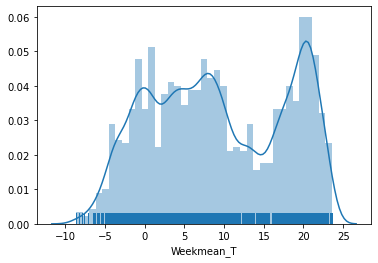

In [28]:
sns.distplot(df_train['Weekmean_T'],kde=True, rug=True)

In [29]:
df_train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,78.188571,-7.142857,0.0,-3.500000,6.573162,5.589715,7.5
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,77.395714,-7.000000,0.0,-3.500000,6.573162,5.589715,7.5
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,77.324286,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,76.440000,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,77.774286,-7.428571,0.0,-3.500000,6.573162,5.589715,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21.5,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,0.0,2.428571,68.254286,-3.000000,0.0,-0.910714,9.479379,8.710275,7.5
52268,1088,22.0,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,0.0,2.514286,66.628571,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5
52269,1088,22.5,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,0.0,2.471429,66.621429,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5
52270,1088,23.0,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,0.0,2.514286,67.664286,-3.571429,0.0,-0.910714,9.479379,8.710275,7.5


In [30]:
def GHI(df):
    h = df['Hour']
    rad = math.pi/180
    l = 37 * rad # 한국의 위도
    alpha = 47/35 # 온도를 이용해 적위를 근사하기 위한 계수
    beta = 23.5-(25*47/35) # 온도를 이용해 적위를 근사하기 위한 계수 2
    a = (alpha*df['Weekmean_T'] + beta) * rad # 선형으로 적위를 근사
    b = np.arcsin(np.sin(a)*np.sin(l) + np.cos(a)*np.cos(l)*np.cos((h*15-180)*(np.pi/180))) # b는 태양의 고도
    df['cos'] =  np.cos((np.pi/2)-b)
    df.loc[df['cos'] < 0,['cos']] = 0 
    df['GHI7']= df['DNI7'] * np.cos((np.pi/2)-b) + df['DHI7'] # GHI 계산식
    return(df) 

In [31]:
GHI(df_train)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,...,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,...,1.800000,78.188571,-7.142857,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,...,1.814286,77.395714,-7.000000,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,...,1.871429,77.324286,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,...,1.842857,76.440000,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,...,1.842857,77.774286,-7.428571,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52267,1088,21.5,30,0.0,0.0,2.4,70.70,-4.0,0.0,0.0,...,2.428571,68.254286,-3.000000,0.0,-0.910714,9.479379,8.710275,7.5,0.0,0.0
52268,1088,22.0,0,0.0,0.0,2.4,66.79,-4.0,0.0,0.0,...,2.514286,66.628571,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5,0.0,0.0
52269,1088,22.5,30,0.0,0.0,2.2,66.78,-4.0,0.0,0.0,...,2.471429,66.621429,-3.285714,0.0,-0.910714,9.479379,8.710275,7.5,0.0,0.0
52270,1088,23.0,0,0.0,0.0,2.1,67.72,-4.0,0.0,0.0,...,2.514286,67.664286,-3.571429,0.0,-0.910714,9.479379,8.710275,7.5,0.0,0.0


In [32]:
df_train.head(n=10)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,...,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0,0.0,0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,...,1.800000,78.188571,-7.142857,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
1,0,0.5,30,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,...,1.814286,77.395714,-7.000000,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
2,0,1.0,0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,...,1.871429,77.324286,-7.285714,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
3,0,1.5,30,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,...,1.842857,76.440000,-7.285714,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
4,0,2.0,0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,...,1.842857,77.774286,-7.428571,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
5,0,2.5,30,0.0,0.0,1.0,87.04,-4.0,0.0,0.0,...,1.814286,76.918571,-7.142857,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
6,0,3.0,0,0.0,0.0,0.9,90.47,-4.0,0.0,0.0,...,1.828571,78.587143,-7.285714,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
7,0,3.5,30,0.0,0.0,0.9,90.47,-4.0,0.0,0.0,...,1.828571,77.798571,-7.285714,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
8,0,4.0,0,0.0,0.0,0.9,87.82,-4.0,0.0,0.0,...,1.857143,78.588571,-7.285714,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0
9,0,4.5,30,0.0,0.0,0.9,87.84,-4.0,0.0,0.0,...,1.871429,77.818571,-7.142857,0.0,-3.5,6.573162,5.589715,7.5,0.0,0.0


In [33]:
Col = df_train['GHI7']>0

In [34]:
df_train[Col]

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,...,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
16,0,8.0,0,8.0,0.0,1.5,78.68,-5.0,0.750824,24.285714,...,2.471429,72.215714,-4.571429,4.223400,-3.500000,6.573162,5.589715,7.5,0.232680,76.040313
17,0,8.5,30,17.0,0.0,1.5,72.89,-4.0,1.595484,45.714286,...,2.628571,64.225714,-3.000000,7.628728,-3.500000,6.573162,5.589715,7.5,0.316670,110.993479
18,0,9.0,0,52.0,0.0,1.5,71.79,-3.0,4.880251,63.428571,...,2.814286,68.064286,-1.714286,12.629631,-3.500000,6.573162,5.589715,7.5,0.392616,178.521150
19,0,9.5,30,40.0,0.0,1.3,66.56,-2.0,3.753998,72.571429,...,2.842857,62.554286,-0.428571,12.387978,-3.500000,6.573162,5.589715,7.5,0.459219,161.594341
20,0,10.0,0,58.0,0.0,1.1,66.10,-1.0,5.443237,112.428571,...,2.914286,63.721429,0.428571,20.405145,-3.500000,6.573162,5.589715,7.5,0.515340,262.907707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52253,1088,14.5,30,93.0,538.0,2.9,43.02,0.0,24.869688,85.000000,...,2.728571,53.501429,3.142857,24.681035,-0.910714,9.479379,8.710275,7.5,0.503464,370.104599
52254,1088,15.0,0,73.0,516.0,2.8,46.51,0.0,19.426511,67.571429,...,2.442857,56.368571,2.428571,19.600199,-0.910714,9.479379,8.710275,7.5,0.435919,309.879892
52255,1088,15.5,30,37.0,756.0,2.4,50.11,-2.0,17.080689,45.285714,...,2.228571,62.357143,0.857143,15.163011,-0.910714,9.479379,8.710275,7.5,0.358898,271.032280
52256,1088,16.0,0,28.0,607.0,2.0,59.31,-4.0,9.197496,31.142857,...,2.085714,62.700000,-0.428571,7.923489,-0.910714,9.479379,8.710275,7.5,0.273719,165.147849


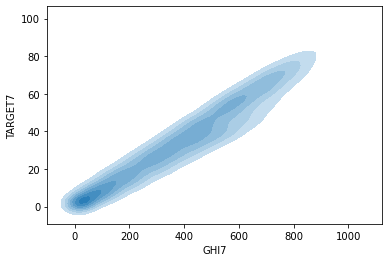

In [35]:
# 그에 따라 PLOT 을 그려본 결과 관계가 매우 뚜렷함을 알 수 있다.
ax = sns.kdeplot(data=df_train[Col]['GHI7'],data2=df_train[Col]['TARGET7'],shade=True,shade_lowest=False)

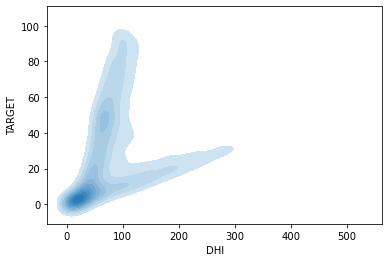

In [36]:
# 다른것들보다 훨씬 우수하다.
ax = sns.kdeplot(data=df_train[Col]['DHI'],data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

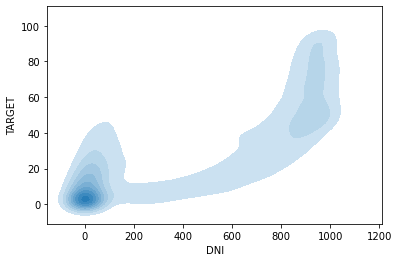

In [37]:
# 이 경우에도 마찬가지
ax = sns.kdeplot(data=df_train[Col]['DNI'],data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

In [38]:
go = df_train[Col]['DNI'] + df_train[Col]['DHI'] 

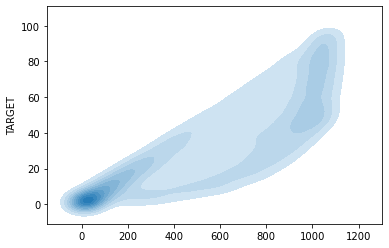

In [39]:
# 둘을 더했을 떄의 경우에도 마찬가지였다.
ax = sns.kdeplot(data=go,data2=df_train[Col]['TARGET'],shade=True,shade_lowest=False)

## train : Day,Minute 삭제하기

In [40]:
df_train.drop(columns = ['Day','Minute'],inplace=True)

## train 1일후, 2일후 Target 추가

In [41]:
df_train['y_1day'] = train['TARGET'].shift(-48*7) # 48 단계 후의 값들을 불러온다. (1일 후의 값들)

In [42]:
df_train['y_2day'] = train['TARGET'].shift(-48*8) # 96 단계 후의의 값들을 불러온다. (2일 후의 값들)

In [43]:
df_train = df_train.iloc[:-96] # 맨 뒤 2일동안의 데이터는 예측할 true 값들이 없기때문에 의미가 없다. 즉 삭제

In [44]:
df_train

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,...,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7,y_1day,y_2day
0,0.0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,...,-7.142857,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
1,0.5,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,...,-7.000000,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,...,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
3,1.5,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,...,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,...,-7.428571,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52171,21.5,0.0,0.0,3.5,55.97,-1.0,0.0,0.0,0.0,2.557143,...,-3.571429,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52172,22.0,0.0,0.0,3.9,54.23,-2.0,0.0,0.0,0.0,2.557143,...,-3.857143,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52173,22.5,0.0,0.0,4.1,54.21,-2.0,0.0,0.0,0.0,2.485714,...,-3.857143,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52174,23.0,0.0,0.0,4.3,56.46,-2.0,0.0,0.0,0.0,2.485714,...,-4.142857,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0


## Test set 에 같은것 적용하기

In [64]:
practice=pd.read_csv('./data/test/0.csv')

In [65]:
preprocess_Test(practice)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,...,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0,0.0,0,0.0,0.0,0.8,80.92,-2.8,0.000000,0.000000,...,1.728571,50.244286,-0.914286,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
1,0,0.5,30,0.0,0.0,0.9,81.53,-2.9,0.000000,0.000000,...,1.742857,50.894286,-1.071429,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
2,0,1.0,0,0.0,0.0,1.0,79.91,-3.0,0.000000,0.000000,...,1.757143,50.887143,-1.214286,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
3,0,1.5,30,0.0,0.0,0.9,79.91,-3.0,0.000000,0.000000,...,1.742857,51.135714,-1.285714,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
4,0,2.0,0,0.0,0.0,0.9,77.20,-3.0,0.000000,0.000000,...,1.771429,51.441429,-1.357143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
5,0,2.5,30,0.0,0.0,1.1,78.36,-3.2,0.000000,0.000000,...,1.828571,51.581429,-1.385714,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
6,0,3.0,0,0.0,0.0,1.2,76.78,-3.4,0.000000,0.000000,...,1.857143,51.871429,-1.457143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
7,0,3.5,30,0.0,0.0,1.8,77.93,-3.6,0.000000,0.000000,...,1.971429,51.837143,-1.442857,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
8,0,4.0,0,0.0,0.0,2.4,76.89,-3.8,0.000000,0.000000,...,2.100000,52.084286,-1.428571,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
9,0,4.5,30,0.0,0.0,2.9,78.64,-4.1,0.000000,0.000000,...,2.185714,52.264286,-1.457143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000


In [47]:
practice.to_csv('c.csv')

In [58]:
def preprocess_Test(df):
    temp = df.copy() # copy 를 떠야 에러가 안난다.
    temp = temp[['Day','Hour','Minute', 'DHI', 'DNI', 'WS', 'RH', 'T','TARGET']]
    data(temp)
    hour(temp)
    Daymean_T(temp)
    sunrise(temp)
    GHI(temp)
    return temp.iloc[-48:, :] 
# 이 때에 -48 로서 1일치만 가져온다는 뜻
# 왜냐하면, 위 모델의 경우 회귀가 단지 이전의 1일차의 값만 가지고 그 뒤 1,2일차의 예측을 하게 되기 떄문이다.

In [59]:
df_test = []
for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_Test(temp)
    df_test.append(temp) # 계속 append 해서 붙여준다.

In [60]:
df_test

[    Day  Hour  Minute    DHI   DNI   WS     RH    T     TARGET        DHI7  \
 0     0   0.0       0    0.0   0.0  0.8  80.92 -2.8   0.000000    0.000000   
 1     0   0.5      30    0.0   0.0  0.9  81.53 -2.9   0.000000    0.000000   
 2     0   1.0       0    0.0   0.0  1.0  79.91 -3.0   0.000000    0.000000   
 3     0   1.5      30    0.0   0.0  0.9  79.91 -3.0   0.000000    0.000000   
 4     0   2.0       0    0.0   0.0  0.9  77.20 -3.0   0.000000    0.000000   
 5     0   2.5      30    0.0   0.0  1.1  78.36 -3.2   0.000000    0.000000   
 6     0   3.0       0    0.0   0.0  1.2  76.78 -3.4   0.000000    0.000000   
 7     0   3.5      30    0.0   0.0  1.8  77.93 -3.6   0.000000    0.000000   
 8     0   4.0       0    0.0   0.0  2.4  76.89 -3.8   0.000000    0.000000   
 9     0   4.5      30    0.0   0.0  2.9  78.64 -4.1   0.000000    0.000000   
 10    0   5.0       0    0.0   0.0  3.5  77.21 -4.3   0.000000    0.000000   
 11    0   5.5      30    0.0   0.0  3.6  79.07 -4.6

In [61]:
X_test = pd.concat(df_test)
X_test.shape

(3888, 21)

In [63]:
X_test.head(n=50)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,DHI7,...,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0,0.0,0,0.0,0.0,0.8,80.92,-2.8,0.000000,0.000000,...,1.728571,50.244286,-0.914286,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
1,0,0.5,30,0.0,0.0,0.9,81.53,-2.9,0.000000,0.000000,...,1.742857,50.894286,-1.071429,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
2,0,1.0,0,0.0,0.0,1.0,79.91,-3.0,0.000000,0.000000,...,1.757143,50.887143,-1.214286,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
3,0,1.5,30,0.0,0.0,0.9,79.91,-3.0,0.000000,0.000000,...,1.742857,51.135714,-1.285714,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
4,0,2.0,0,0.0,0.0,0.9,77.20,-3.0,0.000000,0.000000,...,1.771429,51.441429,-1.357143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
5,0,2.5,30,0.0,0.0,1.1,78.36,-3.2,0.000000,0.000000,...,1.828571,51.581429,-1.385714,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
6,0,3.0,0,0.0,0.0,1.2,76.78,-3.4,0.000000,0.000000,...,1.857143,51.871429,-1.457143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
7,0,3.5,30,0.0,0.0,1.8,77.93,-3.6,0.000000,0.000000,...,1.971429,51.837143,-1.442857,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
8,0,4.0,0,0.0,0.0,2.4,76.89,-3.8,0.000000,0.000000,...,2.100000,52.084286,-1.428571,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000
9,0,4.5,30,0.0,0.0,2.9,78.64,-4.1,0.000000,0.000000,...,2.185714,52.264286,-1.457143,0.000000,0.638988,7.290951,3.280946,7.0,0.000000,0.000000


## Test set 에도 Day 삭제 

In [50]:
X_test.drop(columns = ['Day','Minute'],inplace=True)

In [51]:
df_train

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,...,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7,y_1day,y_2day
0,0.0,0.0,0.0,1.9,86.51,-2.0,0.0,0.0,0.0,1.800000,...,-7.142857,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
1,0.5,0.0,0.0,1.8,86.54,-2.0,0.0,0.0,0.0,1.814286,...,-7.000000,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.7,85.72,-3.0,0.0,0.0,0.0,1.871429,...,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
3,1.5,0.0,0.0,1.4,85.73,-3.0,0.0,0.0,0.0,1.842857,...,-7.285714,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,1.1,87.04,-4.0,0.0,0.0,0.0,1.842857,...,-7.428571,0.0,-3.500000,6.573162,5.589715,7.5,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52171,21.5,0.0,0.0,3.5,55.97,-1.0,0.0,0.0,0.0,2.557143,...,-3.571429,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52172,22.0,0.0,0.0,3.9,54.23,-2.0,0.0,0.0,0.0,2.557143,...,-3.857143,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52173,22.5,0.0,0.0,4.1,54.21,-2.0,0.0,0.0,0.0,2.485714,...,-3.857143,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0
52174,23.0,0.0,0.0,4.3,56.46,-2.0,0.0,0.0,0.0,2.485714,...,-4.142857,0.0,-1.889881,9.590381,8.875729,7.5,0.0,0.0,0.0,0.0


In [53]:
X_test

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0.0,0.0,0.0,0.8,80.92,-2.8,0.0,0.0,0.0,1.728571,50.244286,-0.914286,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
1,0.5,0.0,0.0,0.9,81.53,-2.9,0.0,0.0,0.0,1.742857,50.894286,-1.071429,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
2,1.0,0.0,0.0,1.0,79.91,-3.0,0.0,0.0,0.0,1.757143,50.887143,-1.214286,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
3,1.5,0.0,0.0,0.9,79.91,-3.0,0.0,0.0,0.0,1.742857,51.135714,-1.285714,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
4,2.0,0.0,0.0,0.9,77.20,-3.0,0.0,0.0,0.0,1.771429,51.441429,-1.357143,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,21.5,0.0,0.0,0.8,63.35,13.7,0.0,0.0,0.0,0.857143,68.795714,11.171429,0.0,14.960119,25.312016,23.704122,4.0,0.0,0.0
44,22.0,0.0,0.0,0.7,64.82,13.1,0.0,0.0,0.0,0.900000,69.504286,10.657143,0.0,14.960119,25.312016,23.704122,4.0,0.0,0.0
45,22.5,0.0,0.0,0.7,66.10,12.8,0.0,0.0,0.0,0.985714,71.531429,10.228571,0.0,14.960119,25.312016,23.704122,4.0,0.0,0.0
46,23.0,0.0,0.0,0.6,67.64,12.4,0.0,0.0,0.0,1.042857,72.258571,9.785714,0.0,14.960119,25.312016,23.704122,4.0,0.0,0.0


# Train

In [54]:
# 이 떄에 주 계획은 오늘 데이터로 1일후, 2일 후 데이터를 둘다 근사시키겠다는 뜻 이다.
from sklearn.model_selection import train_test_split
# 1일 후의 값을 예측시키기 위해 
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
# 2일 후의 값을 예측시키기 위함
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

## 잘 나누어졌는지 살펴보기

In [55]:
X_train_1.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
50139,13.5,102.0,705.0,6.2,39.72,14.0,38.847043,94.571429,765.142857,2.971429,24.510000,15.142857,41.460479,6.491071,12.571296,8.828206,6.5,0.723407,648.081287
16823,11.5,73.0,973.0,4.0,38.13,0.0,47.580874,140.428571,483.142857,3.242857,52.638571,2.857143,33.435439,-1.482143,7.832970,8.899910,7.0,0.648564,453.777573
51549,22.5,0.0,0.0,1.0,77.82,-2.0,0.000000,0.000000,0.000000,2.385714,51.084286,-0.428571,0.000000,2.086310,9.685898,7.886676,7.0,0.000000,0.000000
34432,8.0,16.0,0.0,7.0,67.22,0.0,1.501566,29.000000,314.857143,3.514286,58.728571,-1.000000,5.697996,-0.419643,8.497113,5.296566,7.0,0.281393,117.598648
26826,21.0,0.0,0.0,0.4,68.36,20.0,0.000000,0.000000,0.000000,1.485714,57.480000,18.428571,0.000000,22.476190,25.847034,23.212050,4.5,0.000000,0.000000


In [56]:
X_train_2.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
50139,13.5,102.0,705.0,6.2,39.72,14.0,38.847043,94.571429,765.142857,2.971429,24.510000,15.142857,41.460479,6.491071,12.571296,8.828206,6.5,0.723407,648.081287
16823,11.5,73.0,973.0,4.0,38.13,0.0,47.580874,140.428571,483.142857,3.242857,52.638571,2.857143,33.435439,-1.482143,7.832970,8.899910,7.0,0.648564,453.777573
51549,22.5,0.0,0.0,1.0,77.82,-2.0,0.000000,0.000000,0.000000,2.385714,51.084286,-0.428571,0.000000,2.086310,9.685898,7.886676,7.0,0.000000,0.000000
34432,8.0,16.0,0.0,7.0,67.22,0.0,1.501566,29.000000,314.857143,3.514286,58.728571,-1.000000,5.697996,-0.419643,8.497113,5.296566,7.0,0.281393,117.598648
26826,21.0,0.0,0.0,0.4,68.36,20.0,0.000000,0.000000,0.000000,1.485714,57.480000,18.428571,0.000000,22.476190,25.847034,23.212050,4.5,0.000000,0.000000


In [57]:
X_test.head()

,Hour,DHI,DNI,WS,RH,T,TARGET,DHI7,DNI7,WS7,RH7,T7,TARGET7,Weekmean_T,Weekmean_TARGET,Daymean_TARGET,Sunrise,cos,GHI7
0,0.0,0.0,0.0,0.8,80.92,-2.8,0.0,0.0,0.0,1.728571,50.244286,-0.914286,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
1,0.5,0.0,0.0,0.9,81.53,-2.9,0.0,0.0,0.0,1.742857,50.894286,-1.071429,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
2,1.0,0.0,0.0,1.0,79.91,-3.0,0.0,0.0,0.0,1.757143,50.887143,-1.214286,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
3,1.5,0.0,0.0,0.9,79.91,-3.0,0.0,0.0,0.0,1.742857,51.135714,-1.285714,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0
4,2.0,0.0,0.0,0.9,77.20,-3.0,0.0,0.0,0.0,1.771429,51.441429,-1.357143,0.0,0.638988,7.290951,3.280946,7.0,0.0,0.0


In [58]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [59]:
from lightgbm import LGBMRegressor
LGBMRegressor()
# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', # quantile regression 으로서 0.1 ~ 0.9 의 값을 체크한다.
                          alpha=q, # alpha 에 q 를 넣게되면 추정을 quantile 로 해준다.
                          n_estimators=10000,
                          bagging_fraction=0.7,
                          learning_rate=0.1,
                          colsample_bytree = 0.9,
                          max_depth = 20,
                          seed = 42)
    
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
              eval_set=[(X_valid, Y_valid)],
              early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [60]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):
    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()
    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)
    LGBM_actual_pred.columns=quantiles
    return LGBM_models, LGBM_actual_pred

In [61]:
# Target1
# Target1 은 하루 후의 데이터 예측이다.
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.20843
[1000]	valid_0's quantile: 1.20012
Early stopping, best iteration is:
[807]	valid_0's quantile: 1.19626
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.73571
[1000]	valid_0's quantile: 1.68587
[1500]	valid_0's quantile: 1.66333
[2000]	valid_0's quantile: 1.65897
Early stopping, best iteration is:
[1991]	valid_0's quantile: 1.65819
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.02907
[1000]	valid_0's quantile: 1.96985
[1500]	valid_0's quantile: 1.93244
[2000]	valid_0's quantile: 1.91873
[2500]	valid_0's quantile: 1.90592
[3000]	valid_0's quantile: 1.90079
[3500]	valid_0's quantile: 1.89381
[4000]	valid_0's quantile: 1.88981
[4500]	valid_0's quantile: 1.88603
[5000]	valid_0's quantile: 1.88128
[5500]	valid_0's quantile: 1.87725
[6000]	valid_0's quantile: 1.87465
[6500]	valid_0's quantile: 1.87256
[

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [62]:
# Target2
# Target2 는 이틀 뒤의 데이터 예측이다.
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.26564
[1000]	valid_0's quantile: 1.25713
Early stopping, best iteration is:
[816]	valid_0's quantile: 1.25093
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.82407
[1000]	valid_0's quantile: 1.77892
[1500]	valid_0's quantile: 1.75211
[2000]	valid_0's quantile: 1.74021
[2500]	valid_0's quantile: 1.73239
[3000]	valid_0's quantile: 1.72698
[3500]	valid_0's quantile: 1.72119
[4000]	valid_0's quantile: 1.7177
[4500]	valid_0's quantile: 1.71506
[5000]	valid_0's quantile: 1.71258
[5500]	valid_0's quantile: 1.71049
[6000]	valid_0's quantile: 1.70921
[6500]	valid_0's quantile: 1.70712
[7000]	valid_0's quantile: 1.70541
[7500]	valid_0's quantile: 1.70463
Early stopping, best iteration is:
[7604]	valid_0's quantile: 1.70395
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.07578
[1000]	valid_0's quantile: 2.00767
[1

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [63]:
results_1.sort_index().iloc[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [64]:
results_2.sort_index()

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
print(results_1.shape, results_2.shape)

(3888, 9) (3888, 9)


In [66]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values
submission

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.csv_Day7_0h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.csv_Day7_1h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.csv_Day7_1h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.csv_Day7_2h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
7771,80.csv_Day8_21h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7772,80.csv_Day8_22h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7773,80.csv_Day8_22h30m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7774,80.csv_Day8_23h00m,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [67]:
submission.iloc[48:96]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
48,0.csv_Day8_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
49,0.csv_Day8_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50,0.csv_Day8_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
51,0.csv_Day8_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
52,0.csv_Day8_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
53,0.csv_Day8_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
54,0.csv_Day8_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
55,0.csv_Day8_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
56,0.csv_Day8_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57,0.csv_Day8_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [68]:
submission.to_csv('./data/hanadool-submission6repeat.csv', index=False)

In [71]:
a=pd.read_csv('./data/hanadool-submission6repeat.csv')

In [73]:
b=pd.read_csv('./data/hanadool-submission6.csv')